In [37]:
import jax.numpy as jnp
from jax import random, vmap, grad
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF, Linear, Periodic
import timeit
import time

# Full GPR

## Benchmark memory of fitmatrix and fitvector

## Benchmarking with a constant function

In [38]:
# # data_sizes = [100, 200, 500, 1000, 2000, 3000, 4000, 5000]
# data_sizes = [1000, 2000, 3000, 4000, 5000]
# # data_sizes = [6000, 7000, 8000, 10000]

# kernel_1 = RBF()
# kernel_2 = Linear()

### Timing of the training

In [39]:
# for elem in data_sizes:
#     data_split = (elem, )

#     X_data = jnp.linspace(0.0, 1.0, data_split[0]).reshape(-1,1)
#     Y_data =jnp.ones(data_split[0]).reshape(-1,1)

#     def test_RBF():
#         model = gpr.ExactGPR(kernel=kernel_1, init_kernel_params=(1.0,), noise=0.1)
#         model.train(X_data=X_data, Y_data=Y_data, data_split=data_split)

#     print(timeit.repeat(test_RBF, repeat=2, number=1))

### Timing of eval with constant X_grid for different training sizes

In [40]:
# X = jnp.linspace(0.2, 0.8, 10000)

# for elem in data_sizes:
#     data_split = (elem, )

#     X_data = jnp.linspace(0.0, 1.0, data_split[0]).reshape(-1,1)
#     Y_data =jnp.ones(data_split[0]).reshape(-1,1)

#     model = gpr.ExactGPR(kernel=kernel_1, init_kernel_params=(1.0,), noise=0.1)
#     model.train(X_data=X_data, Y_data=Y_data, data_split=data_split)

#     def test_RBF():
#         model.eval(X)


#     print(timeit.repeat(test_RBF, repeat=2, number=1))

# Random functions to try

In [41]:
def plot_tangent(ax,x0, y0, dy0):
    x = jnp.linspace(x0-0.1, x0+0.1,2)
    tangent = dy0*(x - x0) + y0

    ax.plot(x, tangent,ls="--", color="red")

In [42]:
key = random.PRNGKey(int(time.time()))

In [43]:
# bounds = jnp.array([0.0, jnp.pi])
bounds = jnp.array([-1.0, 1.0])

noise = 0.1

length_scale = 1.0

num_datapoints = 5
datagrid = jnp.linspace(*bounds,num_datapoints)
num_derivpoints = (20,)
# derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_grid = random.uniform(key, num_derivpoints, minval=bounds[0], maxval=bounds[1])
data_split = jnp.array((num_datapoints, ) + num_derivpoints)

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)

num_referencepoints = num_derivpoints[0] // 2
permute = random.permutation(key, num_derivpoints[0])[:num_referencepoints]
referencegrid = derivative_grid[permute]

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

# kernel = RBF()
kernel = Periodic()
kernel_params = (length_scale, length_scale, length_scale)#, 1.0, 1.0)

In [44]:
# def f(x, noise=0):
#     return jnp.sin(2*x**2 + 1/(x+0.5/jnp.pi))*x + noise*random.normal(key,x.shape)

# gradient = vmap(grad(f), in_axes=(0,None))

# def df(x, noise=0):
#     return gradient(x, noise) + noise*random.normal(key,x.shape)

def f(x, noise=0.0):
    temp = jnp.where(x<0, -jnp.sin(jnp.pi*x), jnp.cos(2*jnp.pi*x)-1.0)
    return temp + noise*random.normal(key,x.shape)

def df(x, noise=0.0):
    temp = jnp.where(x<0, -jnp.pi*jnp.cos(jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x))
    return temp + noise*random.normal(key,x.shape)

In [45]:
data_values = f(datagrid,noise)
derivative_values = df(derivative_grid,noise)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1)

In [46]:
model_full = gpr.ExactGPR(kernel,kernel_params,noise)
model_full.train(X_data,Y_data,data_split=data_split)
means_full, stds_full = model_full.eval(grid.reshape(-1,1))
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

model_sparse = gpr.SparseGPR(kernel,kernel_params,noise,referencegrid)
model_sparse.train(X_data,Y_data,data_split=data_split)
(means_ppa, stds_ppa) = model_sparse.eval(grid.reshape(-1,1))
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

OptStep(params=DeviceArray([64.30405   ,  0.970405  ,  0.35489222], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(113.2432, dtype=float32, weak_type=True), success=True, status=0, iter_num=13))
OptStep(params=DeviceArray([ 0.8286066,  0.7618945, 38.523434 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(7144.4067, dtype=float32, weak_type=True), success=True, status=0, iter_num=6))


In [47]:
print(stds_full)

[0.09951359 0.09796825 0.09812388 0.10035338 0.26299828 0.4158001
 0.43797058 0.43351457 0.45384002 0.46843252 0.46965244 0.46954685
 0.46966058 0.46802515 0.45696446 0.47570524 0.5293221  0.45258588
 0.18733718 0.15078327 0.16263798 0.11155063 0.11324757 0.11107083
 0.10129924 0.09905252 0.07807615 0.16910048 0.31011048 0.26466104
 0.1970044  0.22646146 0.23262694 0.3386293  0.41759437 0.275356
 1.2731439  2.8313253  4.632457   6.2410297  6.811783   5.8913083
 3.9199812  1.780015   0.2682971  0.4223901  0.24785456 0.15627441
 0.14953847 0.09005579 0.09781238 0.09500302 0.15920065 0.3525918
 0.43837976 0.43264255 0.44183815 0.46343833 0.46969306 0.46983922
 0.46940058 0.47002593 0.46283704 0.45851454 0.50386083 0.52072674
 0.3365048  0.10996632 0.17744438 0.13238096 0.10818268 0.11741515
 0.10088415 0.10597391 0.08491041 0.09955192 0.24902152 0.31501672
 0.20901175 0.21743818 0.22352831 0.2654095  0.40695363 0.32528767
 0.6366528  1.9785098  3.678983   5.4769573  6.692608   6.5482497
 

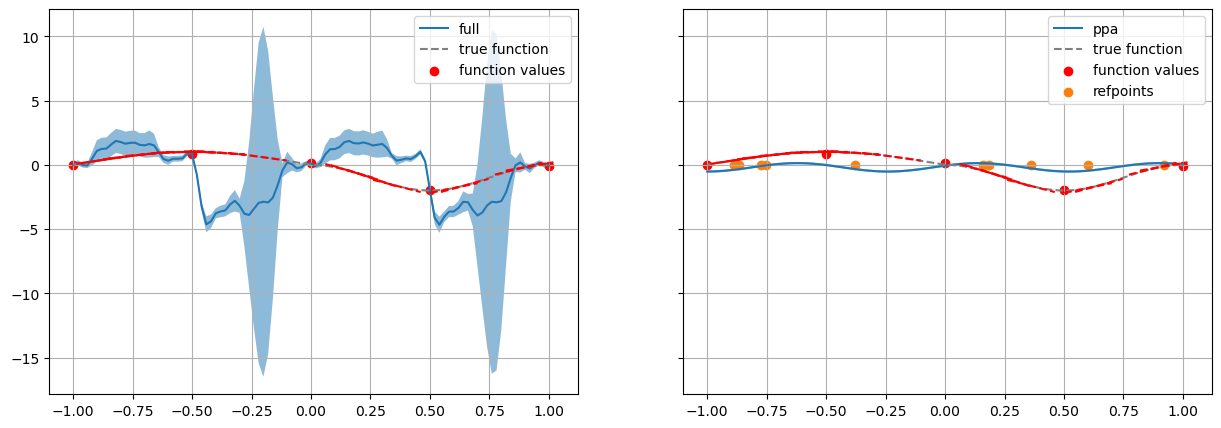

In [48]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharey=True)

ax[0].plot(grid,means_full,label="full")
ax[0].fill_between(grid,means_full-2*stds_full,means_full+2*stds_full,alpha=0.5)
ax[0].plot(grid,f(grid,0.0),color="grey",ls="--",label="true function")
ax[0].scatter(datagrid,data_values,color="r",label="function values")
for i,point in enumerate(derivative_grid):
    plot_tangent(ax[0],point, f(point), derivative_values[i])

    
ax[1].plot(grid,means_ppa,label="ppa")
ax[1].fill_between(grid,means_ppa-2*stds_ppa,means_ppa+2*stds_ppa,alpha=0.5)
ax[1].plot(grid,f(grid,0.0),color="grey",ls="--",label="true function")
ax[1].scatter(datagrid,data_values,color="r",label="function values")
for i,point in enumerate(derivative_grid):
    plot_tangent(ax[1],point, f(point), derivative_values[i])
ax[1].scatter(referencegrid.reshape(-1), -jnp.zeros_like(referencegrid.reshape(-1)), label="refpoints")


ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()